In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import sys
import gzip
from scipy import stats
import scipy as sp
import community

from network_ei import *
from get_motifs import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

# Causal Structure as a Network: Quantifying Certainty in Complex Systems

# Chapter 09: Determinism and Degeneracy

Determinism and degeneracy are two properties that exist in every causal structure, and they govern the degree of certainty about the relationships between causes and effects in a system based on the network connectivity. A visual explanation of these two quantities are shown this notebook. Determinism and degeneracy can be arrived at by decomposing the KL Divergence that defines $EI$, but since they are fundamental to the notion of causality, they can also be built up from first principles, as we do here.

Previously we defined an intervention as introducing random walkers on a node in the network, $do_{net}(v_i)$. The amount of uncertainty in the paths of those random walkers is how much information is lost from noise if the random walker is placed on a $v_i$. This is in turn a function of the strength of the output of a node, i.e., the certainty of transitions or dependencies (the determinism of those transition profiles). Therefore we define the determinism using the average entropy of $W^{out}_{i}$ and the degeneracy with the entropy of $W^{in}$ such that:

\begin{align}
    \text{determinism} &= \text{log}_2(N) - \dfrac{1}{N_{out}}\displaystyle \sum_i^{N_{out}} H[W^{out}_{i}] \tag{4}\\\
    \text{degeneracy} &= \text{log}_2(N) - H[W^{in}] \tag{5}
\end{align}

_______________________________

In a maximally deterministic system wherein all nodes have a single output and every entry in $W^{out}_{i}=1.00$, the determinism is just $\text{log}_2(N)$ because their $H[W^{out}_{i}]=0.00$. Conversely, the degeneracy is the amount of information lost via an overlap in input weights (e.g. if multiple nodes output to the same node). The degeneracy is $\text{log}_2(N) - H[W^{in}]$. In a perfectly non-degenerate system wherein all nodes have an equal input weight, the degeneracy is zero because $H[W^{in}] \approx H_{max}$.

These two quantities provide clear explanations for why canonical networks have the $EI$ they do. For example, as the size of an Erdös-Rényi random network increases, its value for degeneracy approaches zero, which means the the $EI$ of a random network is driven only by the determinism of the network. Similarly, in $d$-dimensional ring lattice networks, the degeneracy term is always zero. Therefore, the \textit{EI} of a ring lattice structure reduces to the determinism of that structure. Ring networks with an average degree $\langle k \rangle$ will have a higher $EI$ than ER networks with the same average degree because ring networks will have a higher determinism value. Interestingly, in the case of star networks, the degeneracy term governs the decay of the $EI$ such that hub-and-spoke-like structures quickly become uninformative in terms of cause and effect.

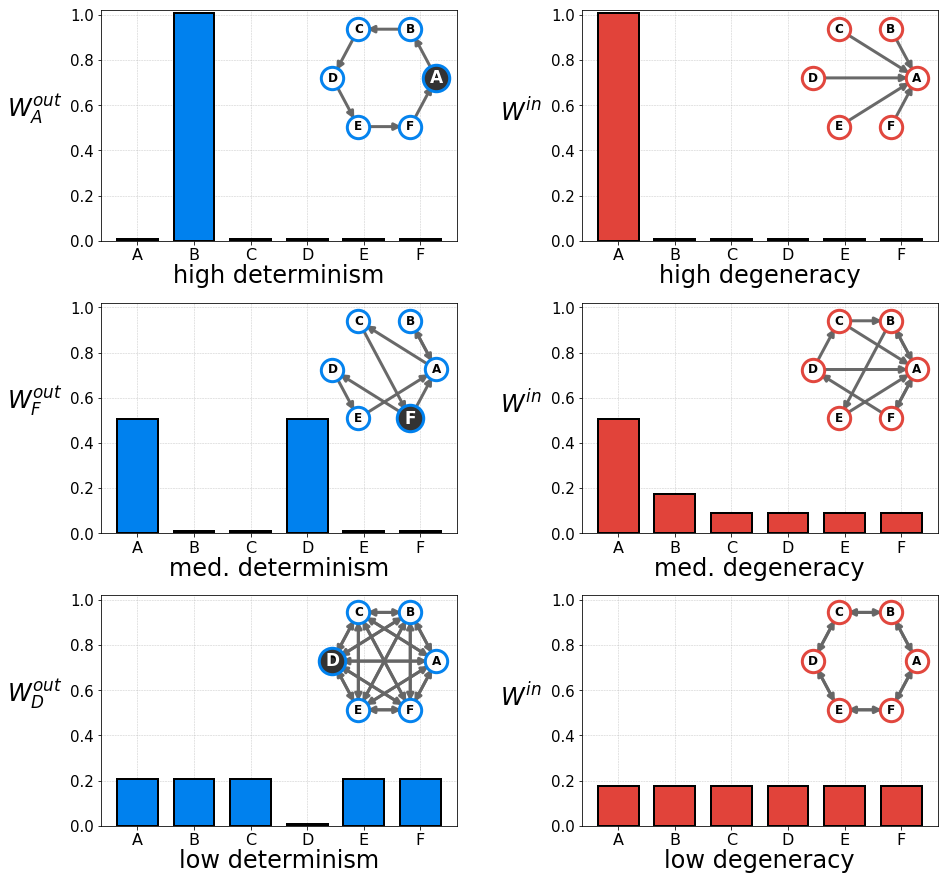

In [2]:
fig, ((ax00, ax01), (ax02, ax03), (ax04, ax05)) = plt.subplots(3, 2, figsize=(15,15))

N = 6

plt.axes([0.325, 0.755, 0.125, 0.125])
G00 = nx.DiGraph()
G00.add_edges_from([(0,1), (1,2), (2,3), (3,4), (4,5), (5,0)])
plt.axis('off')
plt.xlim(-1.3, 1.3)
plt.ylim(-1.2, 1.2)
pos00 = nx.circular_layout(G00)
nx.draw_networkx_nodes(G00, pos00, node_color='white', node_size=500, 
                       linewidths=3.0, alpha=0.98).set_edgecolor('#0081ee')
nx.draw_networkx_nodes(G00, pos00, nodelist=[0], node_color='#333333', linewidths=3.0, 
                       node_size=700).set_edgecolor('#0081ee')
nx.draw_networkx_edges(G00, pos00, edge_color="#666666", width=3.0, alpha=0.98, arrowsize=14)
nx.draw_networkx_labels(G00, pos00, labels=dict(zip([0,1,2,3,4,5], ['A','B','C','D','E','F'])), font_weight='bold')
nx.draw_networkx_labels(G00, pos00, labels=dict(zip([0], ['A'])), font_color='w', font_weight='bold', font_size=17)
ax00.bar(G00.nodes(), get_Wout(G00)[0]+0.009, color='#0081ee', linewidth=2.0, edgecolor='k', width=0.72)
ax00.set_ylim(0.0,1.02)
ax00.set_xticks([0,1,2,3,4,5])
ax00.set_xticklabels(['A','B','C','D','E','F'], fontsize=16)
ax00.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'], fontsize=15)
ax00.set_ylabel(r'$W_{A}^{out}$', fontsize=24, rotation='horizontal', labelpad=35)
ax00.set_xlabel('high determinism', fontsize=24, labelpad=1)
ax00.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax00.set_axisbelow(True)

plt.axes([0.325, 0.485, 0.125, 0.125])
G01 = nx.DiGraph()
G01.add_edges_from([(0,1), (1,0), (0, 2), (3,4), (2,5), (5,0), (5,3), (4, 0)])
plt.axis('off')
plt.xlim(-1.3, 1.3)
plt.ylim(-1.2, 1.2)
pos01 = nx.circular_layout(G01)
nx.draw_networkx_nodes(G01, pos00, node_color='white', node_size=500, 
                       linewidths=3.0, alpha=0.98).set_edgecolor('#0081ee')
nx.draw_networkx_nodes(G01, pos00, nodelist=[5], node_color='#333333', linewidths=3.0, 
                       node_size=700).set_edgecolor('#0081ee')
nx.draw_networkx_edges(G01, pos00, edge_color="#666666", width=3.0, alpha=0.98, arrowsize=14)
nx.draw_networkx_labels(G01, pos00, labels=dict(zip([0,1,2,3,4,5], ['A','B','C','D','E','F'])), font_weight='bold')
nx.draw_networkx_labels(G01, pos00, labels=dict(zip([5], ['F'])), font_color='w', font_weight='bold', font_size=17)
ax02.bar(G01.nodes(), get_Wout(G01)[5]+0.008, color='#0081ee', linewidth=2.0, edgecolor='k', width=0.72)
ax02.set_ylim(0.0,1.02)
ax02.set_xticks([0,1,2,3,4,5])
ax02.set_xticklabels(['A','B','C','D','E','F'], fontsize=16)
ax02.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'], fontsize=15)
ax02.set_ylabel(r'$W_{F}^{out}$', fontsize=24, rotation='horizontal', labelpad=35)
ax02.set_xlabel('med. determinism', fontsize=24, labelpad=1)
ax02.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax02.set_axisbelow(True)

plt.axes([0.325, 0.215, 0.125, 0.125])
G02 = nx.complete_graph(N)
G02 = nx.to_directed(G02)
plt.axis('off')
plt.xlim(-1.3, 1.3)
plt.ylim(-1.2, 1.2)
pos02 = nx.circular_layout(G02)
nx.draw_networkx_nodes(G02, pos00, node_color='white', node_size=500, 
                       linewidths=3.0, alpha=0.98).set_edgecolor('#0081ee')
nx.draw_networkx_nodes(G02, pos00, nodelist=[3], node_color='#333333', linewidths=3.0, 
                       node_size=700).set_edgecolor('#0081ee')
nx.draw_networkx_edges(G02, pos00, edge_color="#666666", width=3.0, alpha=0.98, arrowsize=14)
nx.draw_networkx_labels(G02, pos00, labels=dict(zip([0,1,2,3,4,5], ['A','B','C','D','E','F'])), font_weight='bold')
nx.draw_networkx_labels(G02, pos00, labels=dict(zip([3], ['D'])), font_color='w', font_weight='bold', font_size=17)
ax04.bar(G02.nodes(), get_Wout(G02)[3]+0.008, color='#0081ee', linewidth=2.0, edgecolor='k', width=0.72)
ax04.set_ylim(0.0,1.02)
ax04.set_xticks([0,1,2,3,4,5])
ax04.set_xticklabels(['A','B','C','D','E','F'], fontsize=16)
ax04.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'], fontsize=15)
ax04.set_ylabel(r'$W_{D}^{out}$', fontsize=24, rotation='horizontal', labelpad=35)
ax04.set_xlabel('low determinism', fontsize=24, labelpad=1)
ax04.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax04.set_axisbelow(True)

plt.axes([0.77, 0.755, 0.125, 0.125])
G11 = nx.DiGraph()
G11.add_edges_from([(1,0), (2,0), (3,0), (4,0), (5,0)])
plt.axis('off')
plt.xlim(-1.3, 1.3)
plt.ylim(-1.2, 1.2)
pos11 = nx.circular_layout(G11)
nx.draw_networkx_nodes(G11, pos00, node_color='white', node_size=500, 
                       linewidths=3.0, alpha=0.98).set_edgecolor('#e1433a')
nx.draw_networkx_edges(G11, pos00, edge_color="#666666", width=3.0, alpha=0.98, arrowsize=14)
nx.draw_networkx_labels(G11, pos00, labels=dict(zip([0,1,2,3,4,5], ['A','B','C','D','E','F'])), font_weight='bold')
ax01.bar(G11.nodes(), get_Win(G11)+0.008, color='#e1433a', linewidth=2.0, edgecolor='k', width=0.72)
ax01.set_ylim(0.0,1.02)
ax01.set_xticks([0,1,2,3,4,5])
ax01.set_xticklabels(['A','B','C','D','E','F'], fontsize=16)
ax01.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'], fontsize=15)
ax01.set_ylabel(r'$W^{in}$', fontsize=24, rotation='horizontal', labelpad=30)
ax01.set_xlabel('high degeneracy', fontsize=24, labelpad=1)
ax01.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax01.set_axisbelow(True)

plt.axes([0.77, 0.485, 0.125, 0.125])
G12 = nx.watts_strogatz_graph(6, 2, 0)
G12 = nx.DiGraph()
G12.add_edges_from([(1,0), (3,0), (4,0), (2,0), (1,4), (3,2), (5,3), (0,1), (5,0), (0,5), (2,1)])
plt.axis('off')
plt.xlim(-1.3, 1.3)
plt.ylim(-1.2, 1.2)
pos12 = nx.circular_layout(G12)
nx.draw_networkx_nodes(G12, pos00, node_color='white', node_size=500, 
                       linewidths=3.0, alpha=0.98).set_edgecolor('#e1433a')
nx.draw_networkx_edges(G12, pos00, edge_color="#666666", width=3.0, alpha=0.98, arrowsize=14)
nx.draw_networkx_labels(G12, pos00, labels=dict(zip([0,1,2,3,4,5], ['A','B','C','D','E','F'])), font_weight='bold')
ax03.bar(G12.nodes(), get_Win(G12)+0.008, color='#e1433a', linewidth=2.0, edgecolor='k', width=0.72)
ax03.set_ylim(0.0,1.02)
ax03.set_xticks([0,1,2,3,4,5])
ax03.set_xticklabels(['A','B','C','D','E','F'], fontsize=16)
ax03.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'], fontsize=15)
ax03.set_ylabel(r'$W^{in}$', fontsize=24, rotation='horizontal', labelpad=30)
ax03.set_xlabel('med. degeneracy', fontsize=24, labelpad=1)
ax03.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax03.set_axisbelow(True)

plt.axes([0.77, 0.215, 0.125, 0.125])
G13 = nx.DiGraph()
G13.add_edges_from([(0,1), (1,2), (2,3), (3,4), (4,5), (5,0), (1,0), (2,1), (3,2), (4,3), (5,4), (0,5)])
plt.axis('off')
plt.xlim(-1.3, 1.3)
plt.ylim(-1.2, 1.2)
pos13 = nx.circular_layout(G13)
nx.draw_networkx_nodes(G13, pos00, node_color='white', node_size=500, 
                       linewidths=3.0, alpha=0.98).set_edgecolor('#e1433a')
nx.draw_networkx_edges(G13, pos00, edge_color="#666666", width=3.0, alpha=0.98, arrowsize=14)
nx.draw_networkx_labels(G13, pos00, labels=dict(zip([0,1,2,3,4,5], ['A','B','C','D','E','F'])), font_weight='bold')
ax05.bar(G13.nodes(), get_Win(G13)+0.008, color='#e1433a', linewidth=2.0, edgecolor='k', width=0.72)
ax05.set_ylim(0.0,1.02)
ax05.set_xticks([0,1,2,3,4,5])
ax05.set_xticklabels(['A','B','C','D','E','F'], fontsize=16)
ax05.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'], fontsize=15)
ax05.set_ylabel(r'$W^{in}$', fontsize=24, rotation='horizontal', labelpad=30)
ax05.set_xlabel('low degeneracy', fontsize=24, labelpad=1)
ax05.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax05.set_axisbelow(True)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.27)

# plt.savefig("figs/pngs/EffectiveInformation_DetermDegen_vec.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/EffectiveInformation_DetermDegen_vec.pdf", dpi=425, bbox_inches='tight')

plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


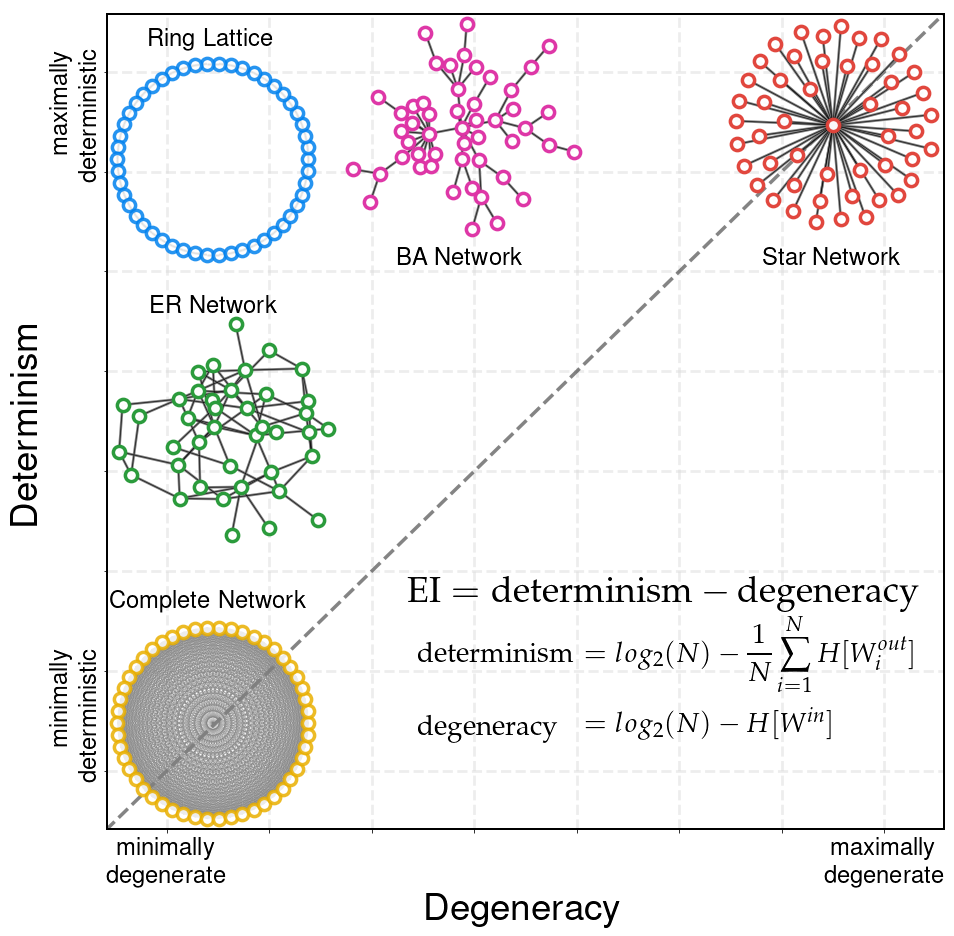

In [30]:
fig, ax = plt.subplots(figsize=(15,15))

plt.plot([-0.5, 10.5], [-0.5, 10.5], marker='', linestyle='--', linewidth=3.5, color='#333333', label='Y=X', alpha=0.6)

ns = 150

plt.axes([0.123, 0.645, 0.20, 0.20])
G10 = nx.watts_strogatz_graph(50, 2, 0.0)
plt.axis('off')
pos10 = nx.circular_layout(G10)
nx.draw_networkx_nodes(G10, pos10, node_color='white', node_size=ns, 
                       linewidths=3.5, alpha=0.85).set_edgecolor('#0081ee')
nx.draw_networkx_edges(G10, pos10, edge_color="grey", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G10, pos10, edge_color="black", width=0.75, alpha=0.8)
ax.text(-.072, 1.085, "Ring Lattice", ha='left', rotation=0, wrap=True, size=24)

plt.axes([0.123, 0.123, 0.20, 0.20])
G11 = nx.complete_graph(50)
plt.axis('off')
pos11 = nx.circular_layout(G11)
nx.draw_networkx_nodes(G11, pos11, node_color='white', node_size=ns, 
                       linewidths=3.5, alpha=0.85).set_edgecolor('#e9af00')
nx.draw_networkx_edges(G11, pos11, edge_color="grey", width=0.25, alpha=0.98)
ax.text(-.130, 0.21, "Complete Network", ha='left', rotation=0, wrap=True, size=24)

plt.axes([0.123, 0.385, 0.22, 0.22])
G12 = nx.erdos_renyi_graph(40, .09)
plt.axis('off')
pos12 = nx.kamada_kawai_layout(G12)
nx.draw_networkx_nodes(G12, pos12, node_color='white', node_size=ns, 
                       linewidths=3.5, alpha=0.99).set_edgecolor('#289a39')
nx.draw_networkx_edges(G12, pos12, edge_color="grey", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G12, pos12, edge_color="black", width=0.75, alpha=0.8)
ax.text(-.069, 0.67, "ER Network", ha='left', rotation=0, wrap=True, size=24)

plt.axes([0.340, 0.668, 0.23, 0.215])
G13 = nx.barabasi_albert_graph(50, 1)
plt.axis('off')
pos13 = nx.kamada_kawai_layout(G13)
nx.draw_networkx_nodes(G13, pos13, node_color='white', node_size=ns, 
                       linewidths=3.5, alpha=0.98).set_edgecolor('#de33a5')
nx.draw_networkx_edges(G13, pos13, edge_color="grey", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G13, pos13, edge_color="black", width=0.75, alpha=0.8)
ax.text(0.305, 0.745, "BA Network", ha='left', rotation=0, wrap=True, size=24)

plt.axes([0.695, 0.675, 0.205, 0.205])
G14 = nx.star_graph(49)
plt.axis('off')
pos14 = nx.spring_layout(G14)
nx.draw_networkx_nodes(G14, pos14, node_color='white', node_size=ns, 
                       linewidths=3.5, alpha=0.98).set_edgecolor('#e1433a')
nx.draw_networkx_edges(G14, pos14, edge_color="grey", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G14, pos14, edge_color="black", width=0.75, alpha=0.8)
ax.text(0.86, 0.745, "Star Network", ha='left', rotation=0, wrap=True, size=24)

font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 24}

plt.axes([0.1, 0.1, 0.2, 0.2])
plt.axis('off')
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
string10 = r'$\rm EI = determinism - degeneracy$'
string21 = r'$\rm determinism$'
string22 = r'$= log_2(N) - ' r'\displaystyle\frac{1}{N}\displaystyle\sum_{i=1}^N H[W_i^{out}]$'
string31 = r'$\rm degeneracy$'
string32 = r'$\hspace{0.6cm}= log_2(N) - ' r'H[W^{in}]$'

ax.text(0.320, 0.2200, string10, ha='left', rotation=0, wrap=True, size=36)
ax.text(0.335, 0.1250, string21, ha='left', rotation=0, wrap=True, size=28)
ax.text(0.590, 0.0780, string22, ha='left', rotation=0, wrap=True, size=28)
ax.text(0.335, 0.0110, string31, ha='left', rotation=0, wrap=True, size=28)
ax.text(0.590, 0.0080, string32, ha='left', rotation=0, wrap=True, size=28)

ax.grid(True, linestyle='--', color='gainsboro', linewidth=2.75, alpha=0.5)
ax.set_xlabel("Degeneracy", size=37)
ax.set_ylabel("Determinism", size=37)
ax.set_xticklabels(labels=['','minimally\n degenerate','', '',  '','', '','', 'maximally\n degenerate',''],
                   size=24)
ax.set_xticks(ticks=np.linspace(-0.2,1.2,num=10))
ax.set_yticklabels(labels=['','','minimally\n deterministic','', '', '', '',  '',' maximally\n deterministic'], 
                   size=24, rotation='vertical')
ax.set_yticks(ticks=np.linspace(-0.2,1.2,num=10))
ax.set_xlim(-0.135,1.135)
ax.set_ylim(-0.135,1.135)
plt.rc('axes', linewidth=2)
# plt.savefig("figs/pngs/EffectiveInformation_DetermDegen.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/EffectiveInformation_DetermDegen.pdf", dpi=425, bbox_inches='tight')

plt.show()

____________________

___________________________

In [3]:
def show_values(pc, ax=ax0, fmt="%.2f", **kw):
    """For bar charts, show the value of the height of the bar."""
    pc.update_scalarmappable()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        plt.text(x, y, fmt % value, ha="center", va="center", size=26, color=color, **kw)

In [4]:
tpm0 = np.array([[0.0,0.0,0.0,0.5,0.5],
                 [1/3,0.0,1/3,1/3,0.0],
                 [0.0,0.5,0.0,0.5,0.0],
                 [0.0,0.0,0.0,0.0,1.0],
                 [0.5,0.0,0.0,0.5,0.0]])

G = nx.from_numpy_array(tpm0, create_using=nx.DiGraph())
ws = np.array(list(nx.get_edge_attributes(G, 'weight').values()))

In [5]:
plt.rc('axes', linewidth=3)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to

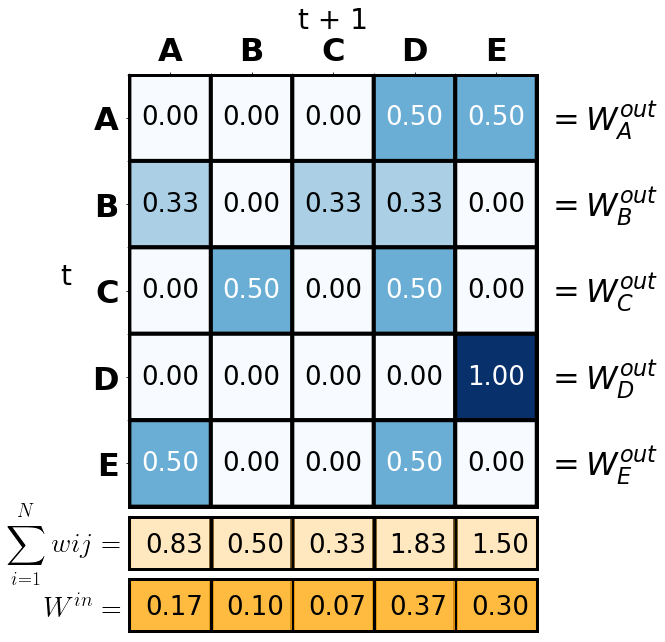

In [6]:
fig = plt.figure(figsize=(7.3, 16))
gs = gridspec.GridSpec(4, 1, height_ratios=[7, 10, 1.2, 1.2]) 

# ax3 = plt.subplot(gs[0])
# pos = nx.circular_layout(G)
# nx.draw_networkx_nodes(G, pos, node_color='aliceblue', node_size=2000, 
#                        linewidths=3.5, alpha=0.99, ax=ax3).set_edgecolor('midnightblue')
# nx.draw_networkx_edges(G, pos, edge_color="#333333", width=4.5, arrowstyle="-|>", 
#                        arrowsize=40, alpha=0.98, ax=ax3)
# nx.draw_networkx_labels(G, pos, labels=dict(zip(np.arange(0, 5, 1), ['A', 'B', 'C', 'D', 'E'])), 
#                         font_size=24, font_color='k', alpha=0.98, font_weight='semibold', ax=ax3)
# ax3.set_axis_off()
# ax3.set_ylim(-2.3, 1.5)
# ax3.set_xlim(-0.8, 0.8)


ax0 = plt.subplot(gs[1])
ax0.set_xticks(np.arange(0, 5, 1))
ax0.set_yticks(np.arange(0, 5, 1))
ax0.set_xticklabels(['A', 'B', 'C', 'D', 'E'], fontsize=32, fontweight='bold')
ax0.set_yticklabels(['A', 'B', 'C', 'D', 'E'], fontsize=32, fontweight='bold')
ax0.set_xticks(np.arange(-.5, 4.5, 1), minor=True)
ax0.set_yticks(np.arange(-.5, 4.5, 1), minor=True)
ax0.tick_params(axis='y', which='major', pad=7)

c = plt.pcolor(np.arange(-.5, 5, 1), np.arange(-.5, 5, 1), tpm0, edgecolors='k', linewidths=4.0, cmap='Blues')
ax0.invert_yaxis()
ax0.xaxis.set_label_position("top")
ax0.xaxis.tick_top()
ax0.set_xlabel('t + 1', size=28, labelpad=8.0)
ax0.set_ylabel('t', size=28, rotation=0, labelpad=27.0)
ax0.xaxis.label.set_position((0.5,5.0))
show_values(c)

ax0.text(4.61, 0.17, '$=W_{A}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.61, 1.17, '$=W_{B}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.61, 2.17, '$=W_{C}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.61, 3.17, '$=W_{D}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.61, 4.17, '$=W_{E}^{out}$', ha='left', rotation=0, wrap=True, size=32)

ms = 78
ax1 = plt.subplot(gs[2])
ax1.plot([4.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.25)
ax1.plot([3.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.25)
ax1.plot([2.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.25)
ax1.plot([1.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.25)
ax1.plot([0.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.25)
ax1.vlines(0.5, -1, 2, linewidth=4.5)
ax1.vlines(1.5, -1, 2, linewidth=4.5)
ax1.vlines(2.5, -1, 2, linewidth=4.5)
ax1.vlines(3.5, -1, 2, linewidth=4.5)
ax1.set_xlim(-0.5,4.5)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(0,1)
vals = tpm0.sum(axis=0)
ax1.text(-.31, 0.32, "%.2f"%vals[0], ha='left', rotation=0, wrap=True, size=26)
ax1.text(0.69, 0.32, "%.2f"%vals[1], ha='left', rotation=0, wrap=True, size=26)
ax1.text(1.69, 0.32, "%.2f"%vals[2], ha='left', rotation=0, wrap=True, size=26)
ax1.text(2.69, 0.32, "%.2f"%vals[3], ha='left', rotation=0, wrap=True, size=26)
ax1.text(3.69, 0.32, "%.2f"%vals[4], ha='left', rotation=0, wrap=True, size=26)

ax2 = plt.subplot(gs[3])
ax2.plot([4.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.75)
ax2.plot([3.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.75)
ax2.plot([2.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.75)
ax2.plot([1.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.75)
ax2.plot([0.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.75)
ax2.vlines(0.5, -1, 2, linewidth=4.5)
ax2.vlines(1.5, -1, 2, linewidth=4.5)
ax2.vlines(2.5, -1, 2, linewidth=4.5)
ax2.vlines(3.5, -1, 2, linewidth=4.5)
ax2.set_xlim(-0.5,4.5)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(0,1)
ax2.text(-.31, 0.32, "%.2f"%(vals[0]/5), ha='left', rotation=0, wrap=True, size=26)
ax2.text(0.69, 0.32, "%.2f"%(vals[1]/5), ha='left', rotation=0, wrap=True, size=26)
ax2.text(1.69, 0.32, "%.2f"%(vals[2]/5), ha='left', rotation=0, wrap=True, size=26)
ax2.text(2.69, 0.32, "%.2f"%(vals[3]/5), ha='left', rotation=0, wrap=True, size=26)
ax2.text(3.69, 0.32, "%.2f"%(vals[4]/5), ha='left', rotation=0, wrap=True, size=26)

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
string10 = r'$\displaystyle\sum_{i=1}^N w{ij} =$'
string20 = r'$W^{in} =$'

ax1.text(-2.0, -0.3, string10, ha='left', rotation=0, wrap=True, size=28)
ax2.text(-1.55, 0.295, string20, ha='left', rotation=0, wrap=True, size=29)

plt.subplots_adjust(wspace=0, hspace=0.05)

plt.savefig("figs/pngs/EffectiveInfoCalculation_Network_TPM1.png", dpi=425, bbox_inches='tight')
plt.savefig("figs/pdfs/EffectiveInfoCalculation_Network_TPM1.pdf", dpi=425, bbox_inches='tight')
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


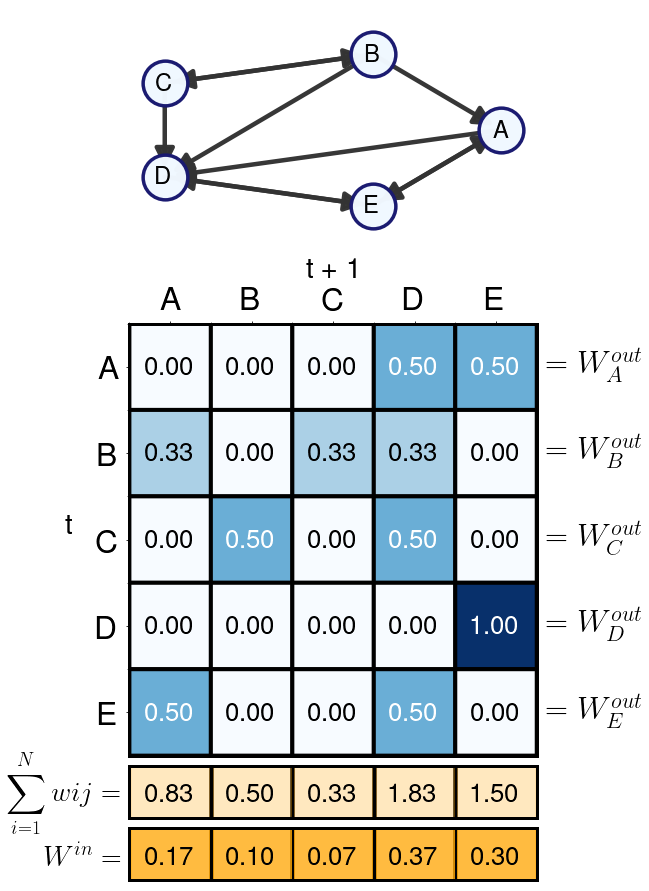

In [99]:
fig = plt.figure(figsize=(7.3, 16))
gs = gridspec.GridSpec(4, 1, height_ratios=[7, 10, 1.2, 1.2]) 

ax3 = plt.subplot(gs[0])
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='aliceblue', node_size=2000, 
                       linewidths=3.5, alpha=0.99, ax=ax3).set_edgecolor('midnightblue')
nx.draw_networkx_edges(G, pos, edge_color="#333333", width=4.5, arrowstyle="-|>", 
                       arrowsize=40, alpha=0.98, ax=ax3)
nx.draw_networkx_labels(G, pos, labels=dict(zip(np.arange(0, 5, 1), ['A', 'B', 'C', 'D', 'E'])), 
                        font_size=24, font_color='k', alpha=0.98, font_weight='semibold', ax=ax3)
ax3.set_axis_off()
ax3.set_ylim(-2.3, 1.5)
# ax3.set_xlim(-0.8, 0.8)


ax0 = plt.subplot(gs[1])
ax0.set_xticks(np.arange(0, 5, 1))
ax0.set_yticks(np.arange(0, 5, 1))
ax0.set_xticklabels(['A', 'B', 'C', 'D', 'E'], fontsize=32, fontweight='bold')
ax0.set_yticklabels(['A', 'B', 'C', 'D', 'E'], fontsize=32, fontweight='bold')
ax0.set_xticks(np.arange(-.5, 4.5, 1), minor=True)
ax0.set_yticks(np.arange(-.5, 4.5, 1), minor=True)
ax0.tick_params(axis='y', which='major', pad=7)

c = plt.pcolor(np.arange(-.5, 5, 1), np.arange(-.5, 5, 1), tpm0, edgecolors='k', linewidths=4.0, cmap='Blues')
ax0.invert_yaxis()
ax0.xaxis.set_label_position("top")
ax0.xaxis.tick_top()
ax0.set_xlabel('t + 1', size=28, labelpad=8.0)
ax0.set_ylabel('t', size=28, rotation=0, labelpad=27.0)
ax0.xaxis.label.set_position((0.5,5.0))
show_values(c)

ax0.text(4.61, 0.17, '$=W_{A}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.61, 1.17, '$=W_{B}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.61, 2.17, '$=W_{C}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.61, 3.17, '$=W_{D}^{out}$', ha='left', rotation=0, wrap=True, size=32)
ax0.text(4.61, 4.17, '$=W_{E}^{out}$', ha='left', rotation=0, wrap=True, size=32)

ms = 78
ax1 = plt.subplot(gs[2])
ax1.plot([4.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.25)
ax1.plot([3.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.25)
ax1.plot([2.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.25)
ax1.plot([1.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.25)
ax1.plot([0.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.25)
ax1.vlines(0.5, -1, 2, linewidth=4.5)
ax1.vlines(1.5, -1, 2, linewidth=4.5)
ax1.vlines(2.5, -1, 2, linewidth=4.5)
ax1.vlines(3.5, -1, 2, linewidth=4.5)
ax1.set_xlim(-0.5,4.5)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(0,1)
vals = tpm0.sum(axis=0)
ax1.text(-.31, 0.32, "%.2f"%vals[0], ha='left', rotation=0, wrap=True, size=26)
ax1.text(0.69, 0.32, "%.2f"%vals[1], ha='left', rotation=0, wrap=True, size=26)
ax1.text(1.69, 0.32, "%.2f"%vals[2], ha='left', rotation=0, wrap=True, size=26)
ax1.text(2.69, 0.32, "%.2f"%vals[3], ha='left', rotation=0, wrap=True, size=26)
ax1.text(3.69, 0.32, "%.2f"%vals[4], ha='left', rotation=0, wrap=True, size=26)

ax2 = plt.subplot(gs[3])
ax2.plot([4.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.75)
ax2.plot([3.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.75)
ax2.plot([2.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.75)
ax2.plot([1.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.75)
ax2.plot([0.00], [0.5], marker='s', markersize=ms, color='orange', alpha=0.75)
ax2.vlines(0.5, -1, 2, linewidth=4.5)
ax2.vlines(1.5, -1, 2, linewidth=4.5)
ax2.vlines(2.5, -1, 2, linewidth=4.5)
ax2.vlines(3.5, -1, 2, linewidth=4.5)
ax2.set_xlim(-0.5,4.5)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(0,1)
ax2.text(-.31, 0.32, "%.2f"%(vals[0]/5), ha='left', rotation=0, wrap=True, size=26)
ax2.text(0.69, 0.32, "%.2f"%(vals[1]/5), ha='left', rotation=0, wrap=True, size=26)
ax2.text(1.69, 0.32, "%.2f"%(vals[2]/5), ha='left', rotation=0, wrap=True, size=26)
ax2.text(2.69, 0.32, "%.2f"%(vals[3]/5), ha='left', rotation=0, wrap=True, size=26)
ax2.text(3.69, 0.32, "%.2f"%(vals[4]/5), ha='left', rotation=0, wrap=True, size=26)

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
string10 = r'$\displaystyle\sum_{i=1}^N w{ij} =$'
string20 = r'$W^{in} =$'

ax1.text(-2.0, -0.3, string10, ha='left', rotation=0, wrap=True, size=28)
ax2.text(-1.55, 0.295, string20, ha='left', rotation=0, wrap=True, size=29)

plt.subplots_adjust(wspace=0, hspace=0.05)

plt.savefig("figs/pngs/EffectiveInfoCalculation_Network_TPM.png", dpi=425, bbox_inches='tight')
plt.savefig("figs/pdfs/EffectiveInfoCalculation_Network_TPM.pdf", dpi=425, bbox_inches='tight')
plt.show()

_______________________

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


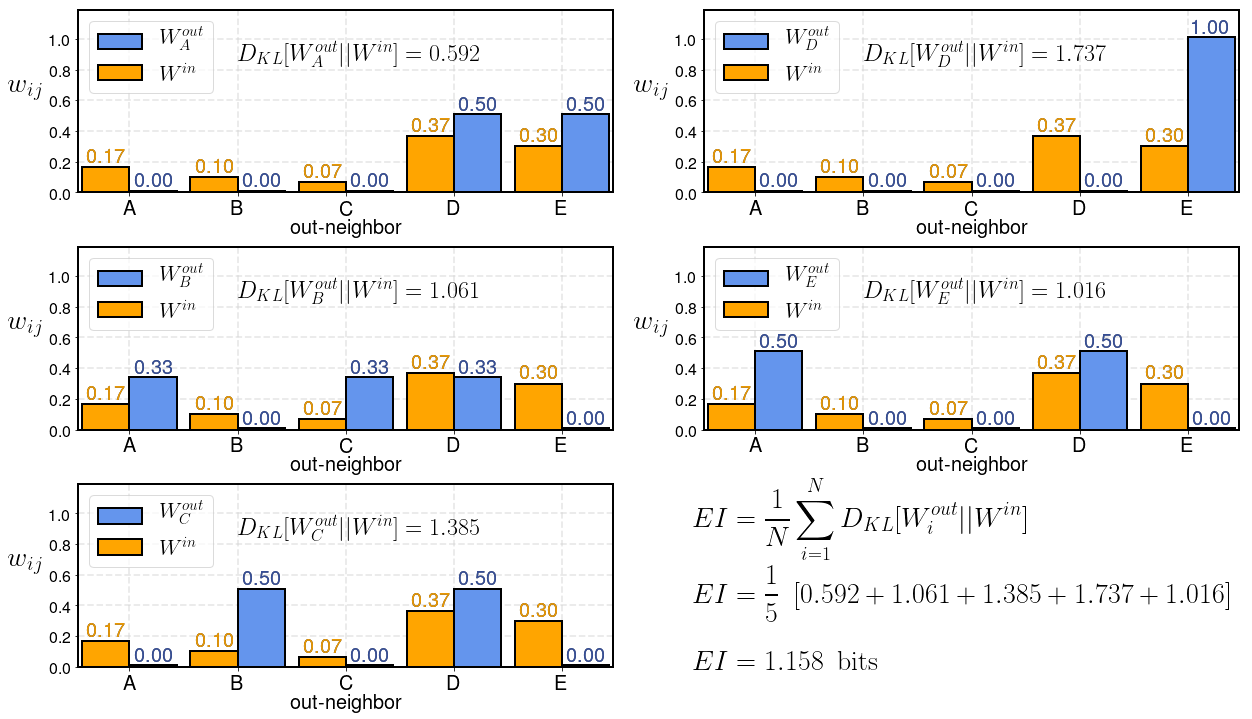

In [89]:
plt.rc('axes', linewidth=2)
fig, ((ax00, ax01), (ax02, ax03), (ax04, ax05)) = plt.subplots(3, 2, figsize=(16*1.3,9*1.3))

outcol = 'cornflowerblue'
ax00.bar(np.linspace(0.0, 5.5, 5), tpm0[0]+0.01, color=outcol, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W_{A}^{out}$')
x_wij = np.linspace(0.0, 5.5, 5)
y_wij = tpm0[0]
for i in range(len(x_wij)):
    ax00.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='#262626')
    ax00.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='royalblue', alpha=0.6)
    
ax00.set_xticklabels(["A", "B", "C", "D", "E"])
ax00.bar(np.linspace(-.6, 4.9, 5), vals/5, color='orange', linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W^{in}$')

x_wij = np.linspace(-.6, 4.9, 5)
y_wij = vals/5
for i in range(len(x_wij)):
    ax00.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='#262626')
    ax00.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='orange', alpha=0.9)

ax00.set_ylim(0.0,1.19)
ax00.set_xlim(-0.95,5.85)
ax00.set_xticks(np.linspace(-.3, 5.2, 5))
ax00.set_yticks(np.linspace(0, 1, 6))
ax00.set_yticklabels(np.round(np.linspace(0, 1, 6), 2), size=16)
ax00.set_xticklabels(["A", "B", "C", "D", "E"], size=20, fontweight='semibold')
ax00.set_ylabel(r'$w_{ij}$', fontsize=28, rotation='horizontal', labelpad=25)
ax00.set_xlabel('out-neighbor', fontsize=20, labelpad=0)
ax00.set_axisbelow(True)
ax00.grid(which='major', linestyle='--', color='lightgrey', linewidth=1.75, alpha=0.5)
ax00.legend(loc=2, fontsize=22, framealpha=0.7)
strax1 = r'$D_{KL}[W^{out}_{A}||W^{in}] = %.3f $'%get_ei_i(tpm0, p0=0)[0]
ax00.text(2.62, 0.825, strax1, ha='center', fontsize=24, color='k')

ax02.bar(np.linspace(0.0, 5.5, 5), tpm0[1]+0.01, color=outcol, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W_{B}^{out}$')
x_wij = np.linspace(0.0, 5.5, 5)
y_wij = tpm0[1]
for i in range(len(x_wij)):
    ax02.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='#262626')
    ax02.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='royalblue', alpha=0.6)

ax02.set_xticklabels(["A", "B", "C", "D", "E"])
ax02.bar(np.linspace(-.6, 4.9, 5), vals/5, color='orange', linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W^{in}$')
x_wij = np.linspace(-.6, 4.9, 5)
y_wij = vals/5
for i in range(len(x_wij)):
    ax02.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='#262626')
    ax02.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='orange', alpha=0.9)

ax02.set_ylim(0.0,1.19)
ax02.set_xlim(-0.95,5.85)
ax02.set_xticks(np.linspace(-.3, 5.2, 5))
ax02.set_yticks(np.linspace(0, 1, 6))
ax02.set_yticklabels(np.round(np.linspace(0, 1, 6), 2), size=16)
ax02.set_xticklabels(["A", "B", "C", "D", "E"], size=20, fontweight='semibold')
ax02.set_ylabel(r'$w_{ij}$', fontsize=28, rotation='horizontal', labelpad=25)
ax02.set_xlabel('out-neighbor', fontsize=20, labelpad=0)
ax02.set_axisbelow(True)
ax02.grid(which='major', linestyle='--', color='lightgrey', linewidth=1.75, alpha=0.5)
ax02.legend(loc=2, fontsize=22, framealpha=0.7)
strax1 = r'$D_{KL}[W^{out}_{B}||W^{in}] = %.3f $'%get_ei_i(tpm0, p0=0)[1]
ax02.text(2.62, 0.825, strax1, ha='center', fontsize=24, color='k')

ax04.bar(np.linspace(0.0, 5.5, 5), tpm0[2]+0.01, color=outcol, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W_{C}^{out}$')
x_wij = np.linspace(0.0, 5.5, 5)
y_wij = tpm0[2]
for i in range(len(x_wij)):
    ax04.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='#262626')
    ax04.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='royalblue', alpha=0.6)

ax04.set_xticklabels(["A", "B", "C", "D", "E"])
ax04.bar(np.linspace(-.6, 4.9, 5), vals/5, color='orange', linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W^{in}$')

x_wij = np.linspace(-.6, 4.9, 5)
y_wij = vals/5
for i in range(len(x_wij)):
    ax04.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='#262626')
    ax04.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='orange', alpha=0.9)

ax04.set_ylim(0.0,1.19)
ax04.set_xlim(-0.95,5.85)
ax04.set_xticks(np.linspace(-.3, 5.2, 5))
ax04.set_yticks(np.linspace(0, 1, 6))
ax04.set_yticklabels(np.round(np.linspace(0, 1, 6), 2), size=16)
ax04.set_xticklabels(["A", "B", "C", "D", "E"], size=20, fontweight='semibold')
ax04.set_ylabel(r'$w_{ij}$', fontsize=28, rotation='horizontal', labelpad=25)
ax04.set_xlabel('out-neighbor', fontsize=20, labelpad=0)
ax04.set_axisbelow(True)
ax04.grid(which='major', linestyle='--', color='lightgrey', linewidth=1.75, alpha=0.5)
ax04.legend(loc=2, fontsize=22, framealpha=0.7)
strax1 = r'$D_{KL}[W^{out}_{C}||W^{in}] = %.3f $'%get_ei_i(tpm0, p0=0)[2]
ax04.text(2.62, 0.825, strax1, ha='center', fontsize=24, color='k')


ax01.bar(np.linspace(0.0, 5.5, 5), tpm0[3]+0.01, color=outcol, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W_{D}^{out}$')
x_wij = np.linspace(0.0, 5.5, 5)
y_wij = tpm0[3]
for i in range(len(x_wij)):
    ax01.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='#262626')
    ax01.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='royalblue', alpha=0.6)

ax01.set_xticklabels(["A", "B", "C", "D", "E"])
ax01.bar(np.linspace(-.6, 4.9, 5), vals/5, color='orange', linewidth=2.0, edgecolor='k',
     width=0.6, label=r'$W^{in}$')

x_wij = np.linspace(-.6, 4.9, 5)
y_wij = vals/5
for i in range(len(x_wij)):
    ax01.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='#262626')
    ax01.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='orange', alpha=0.9)

ax01.set_ylim(0.0,1.19)
ax01.set_xlim(-0.95,5.85)
ax01.set_xticks(np.linspace(-.3, 5.2, 5))
ax01.set_yticks(np.linspace(0, 1, 6))
ax01.set_yticklabels(np.round(np.linspace(0, 1, 6), 2), size=16)
ax01.set_xticklabels(["A", "B", "C", "D", "E"], size=20, fontweight='semibold')
ax01.set_ylabel(r'$w_{ij}$', fontsize=28, rotation='horizontal', labelpad=25)
ax01.set_xlabel('out-neighbor', fontsize=20, labelpad=0)
ax01.set_axisbelow(True)
ax01.grid(which='major', linestyle='--', color='lightgrey', linewidth=1.75, alpha=0.5)
ax01.legend(loc=2, fontsize=22, framealpha=0.7)
strax1 = r'$D_{KL}[W^{out}_{D}||W^{in}] = %.3f $'%get_ei_i(tpm0, p0=0)[3]
ax01.text(2.62, 0.825, strax1, ha='center', fontsize=24, color='k')

ax03.bar(np.linspace(0.0, 5.5, 5), tpm0[4]+0.01, color=outcol, linewidth=2.0, edgecolor='k',
         width=0.6, label=r'$W_{E}^{out}$')
x_wij = np.linspace(0.0, 5.5, 5)
y_wij = tpm0[4]
for i in range(len(x_wij)):
    ax03.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='#262626')
    ax03.text(x_wij[i], y_wij[i]+0.040, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='royalblue', alpha=0.6)

ax03.set_xticklabels(["A", "B", "C", "D", "E"])
ax03.bar(np.linspace(-.6, 4.9, 5), vals/5, color='orange', linewidth=2.0, edgecolor='k',
     width=0.6, label=r'$W^{in}$')

x_wij = np.linspace(-.6, 4.9, 5)
y_wij = vals/5
for i in range(len(x_wij)):
    ax03.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='#262626')
    ax03.text(x_wij[i], y_wij[i]+0.035, "%.2f"%y_wij[i], ha='center', #fontweight='semibold',
              fontsize=20, color='orange', alpha=0.9)

ax03.set_ylim(0.0,1.19)
ax03.set_xlim(-0.95,5.85)
ax03.set_xticks(np.linspace(-.3, 5.2, 5))
ax03.set_yticks(np.linspace(0, 1, 6))
ax03.set_yticklabels(np.round(np.linspace(0, 1, 6), 2), size=16)
ax03.set_xticklabels(["A", "B", "C", "D", "E"], size=20, fontweight='semibold')
ax03.set_ylabel(r'$w_{ij}$', fontsize=28, rotation='horizontal', labelpad=25)
ax03.set_xlabel('out-neighbor', fontsize=20, labelpad=0)
ax03.set_axisbelow(True)
ax03.grid(which='major', linestyle='--', color='lightgrey', linewidth=1.75, alpha=0.5)
ax03.legend(loc=2,fontsize=22, framealpha=0.7)
strax1 = r'$D_{KL}[W^{out}_{E}||W^{in}] = %.3f $'%get_ei_i(tpm0, p0=0)[4]
ax03.text(2.62, 0.825, strax1, ha='center', fontsize=24, color='k')

string1 = r'$EI = \displaystyle\frac{1}{N} \displaystyle\sum_{i=1}^N D_{KL}[W_{i}^{out}|| W^{in}]$'
string2 = r'$EI = \displaystyle\frac{1}{5} \hspace{0.5cm} [0.592 + 1.061 + 1.385 + 1.737 + 1.016]$'
string3 = r'$EI = 1.158 \hspace{0.5cm}$' r'$\rm bits$'
ax05.text(-.02, 0.590, string1, ha='left', rotation=0, wrap=False, size=28)
ax05.text(-.02, 0.250, string2, ha='left', rotation=0, wrap=False, size=28)
ax05.text(-.02, -0.01, string3, ha='left', rotation=0, wrap=False, size=28)

ax05.axis('off')

plt.subplots_adjust(left=None, bottom=0.1, right=None, top=None, wspace=0.17, hspace=0.3)

plt.savefig("figs/pngs/EffectiveInfoCalculation_KLD.png", dpi=425, bbox_inches='tight')
plt.savefig("figs/pdfs/EffectiveInfoCalculation_KLD.pdf", dpi=425, bbox_inches='tight')

plt.show()

__________________________